# Import Dependencies

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import deepgraph as dg
from mpl_toolkits.basemap import Basemap

%matplotlib inline

plt.style.use("ggplot")

# Selecting Data From the Database

In [2]:
# Create the connection with the database
connection = psycopg2.connect(dbname='geocenter',
                              user='vmtai', 
                              host='cslvm74.csc.calpoly.edu', 
                              password='vmtai')

cur = connection.cursor()
 
query = """
SELECT
  A.id,
  A.version,
  B.id,
  B.version,
  B.author,
  ST_X(A.point),
  ST_Y(A.point),
  ST_X(B.point),
  ST_Y(B.point),
  ST_Distance(A.point, B.point) as dist
FROM (SELECT
        C.id,
        C.version,
        C.point,
        D.timestamp,
        D.author
      FROM (node C
        JOIN osm_entity D ON C.id = D.id AND C.version = D.version)
      WHERE author = 'bigalxyz123' AND extract(YEAR FROM D.timestamp) > 2016) A
  JOIN (SELECT
          N.id,
          N.version,
          N.point,
          O.author
        FROM (node N
          JOIN osm_entity O ON N.id = O.id AND N.version = O.version)
        WHERE extract(YEAR FROM O.timestamp) > 2016 and author != 'bigalxyz123') B ON ST_DWithin(A.point, B.point, 500)
where A.id != B.id limit 500000;
"""
cur.execute(query)
queried_data = cur.fetchall()

# Creating the Deep Graph

In [3]:
# Load the data into a pandas dataframe
youth_data = pd.DataFrame(queried_data, columns = ["A_id", "A_version", "B_id", 
                                                   "B_version", "B_author","A_lat", "A_lon", 
                                                   "B_lat", "B_lon", "Distance"])

In [4]:
youth_data.head()

,A_id,A_version,B_id,B_version,B_author,A_lat,A_lon,B_lat,B_lon,Distance
0,5113798224,1,4906132454,1,Hills95,53.493045,-0.624736,-17.909742,30.930817,78.064787
1,5113798224,1,4782026882,1,prosper1994,53.493045,-0.624736,-19.155132,28.124201,78.129757
2,5113798224,1,4782026881,1,prosper1994,53.493045,-0.624736,-19.155131,28.124253,78.129776
3,5113798224,1,4782026880,1,prosper1994,53.493045,-0.624736,-19.155200,28.124253,78.129840
4,5113798224,1,4782026883,1,prosper1994,53.493045,-0.624736,-19.155200,28.124202,78.129821


In [5]:
subset_youth_data = youth_data.sample(1000)

In [6]:
graph = dg.DeepGraph(subset_youth_data)

Below I am creating the functions on how to connect each edge. I calculate the lat and lon distane from one point to the next and then I select only users that are within 90m of one another.

In [7]:
def great_circle(B_lat_s, B_lat_t, B_lon_s, B_lon_t):
    dist = dg.functions.great_circle_dist(B_lat_s, B_lat_t, B_lon_s, B_lon_t)
    return dist

I tried to reduce the selection criteria, but there were some errors. I will be trying to fix this in the next meeting.

In [8]:
def dist_selector(dist, sources, targets):
    dista = np.abs(dist)
    sources = sources[dista <= 200]
    targets = targets[dista <= 200]
    return sources, targets

In [9]:
# Create the graphs based on what criteria to connect and select
graph.create_edges(connectors = great_circle,
                   selectors = dist_selector)

In [10]:
graph.e

dist
s      t                 
5374   338983  195.458797
       400889  134.004604
       312706  196.785846
       214024   67.975167
       481817   78.381918
       457207  199.002685
       214825   63.583092
       456797  112.179528
       397414  132.012324
       42133   113.823573
       485547   77.272868
       312532  196.406921
       436582  119.401907
       442373  109.548991
       400785  133.677197
       273037   65.694492
       438686  119.567015
       232285   76.356216
       176632  107.864030
       328159   59.434415
       468584  190.507247
       428563  117.843264
       66442   120.620995
       231192   55.063549
       441541  114.988137
       49928   164.614017
       168712  109.430794
       40009   130.515244
       446577  178.791134
       482758  181.487451
...                   ...
14529  400288  104.004309
       449543  178.457344
87531  22996   119.307337
       155804  142.489097
       449543  168.529660
22996  155804   82.414132
       449543  172.188244
271883 340897  126.768040
       283358   56.852385
       278117   49.204715
       400288  153.173426
       92982   156.933872
       449543  185.598549
340897 283358   99.045052
       278117   80.876476
       491450  106.875713
       155804  160.251554
       449543   65.670542
283358 278117   30.255905
       491450  152.073809
       92982   173.024508
       449543  164.440318
278117 491450  155.130551
       400288  178.674527
       92982   191.650485
       449543  143.810254
91030  400288  136.010175
491450 155804  168.876135
       449543  127.020152
155804 449543   98.868780

[130237 rows x 1 columns]

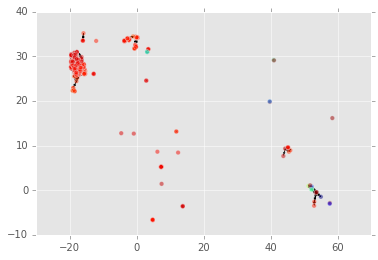

In [11]:
# Plotting the lat and lon as a scatterplot
obj = graph.plot_2d("B_lat", "B_lon", edges = True,
                kwds_scatter = {'c': graph.v.B_id,
                                'alpha': 0.5})


In [12]:
# Parameters for the map graph
kwds_basemap = {'llcrnrlon': graph.v.B_lon.min() - 40,
                'urcrnrlon': graph.v.B_lon.max() + 20,
                'llcrnrlat': graph.v.B_lat.min() - 20,
                'urcrnrlat': graph.v.B_lat.max() + 20,
                'resolution': 'i'}

kwds_scatter = {'s': 1, 
                'c': graph.v.B_id,
                'edgecolors':'none'}

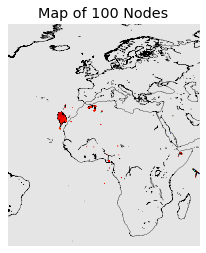

In [13]:
# Mapping the nodes
objs = graph.plot_map("B_lat", "B_lon",
                       edges = True,
                       kwds_basemap = kwds_basemap,
                       kwds_scatter = kwds_scatter)

objs['m'].drawcoastlines(linewidth=.3)
objs['ax'].set_title("Map of 100 Nodes")

I wanted to make a graph which each user to other users dependent on their nodes. In future exploration, I will be adding time into the analysis. Picking the users based on the when they started making a node and then calculating how far away they are from other users and how close they are in proximity of time.